# Mars Curiosity Rover (MSL) SimCLRv2
Run through using contrastive learning method SimCLRv2 on Mars Rover dataset.

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import sys
import argparse
import datetime
import shutil
from pprint import pprint
from pathlib import Path
from GPUtil import showUtilization

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

sys.path.insert(0, '../../../SimCLRv2-PyTorch/')

from utils.model import save_model, load_optimizer
from simclr.modules import LogisticRegression
from simclr import SimCLRv2, SimCLRv2_ft
from simclr.modules import get_resnet, NT_Xent
from simclr.modules.transformations import TransformsSimCLR
from utils import yaml_config_hook
from utils.img_dataset_utils import *

In [9]:
simclr_repo = Path('/home/kaipak/dev/SimCLRv2-PyTorch/')
parser = argparse.ArgumentParser(description="SimCLR")
config = yaml_config_hook('simclrv2_config_marsv2.yaml')
tb_out = Path('/home/kaipak/models/tensorboard_logs')

for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
    
args = parser.parse_args([])
args.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
config

{'nodes': 1,
 'gpus': 4,
 'nr': 0,
 'dataparallel': 0,
 'workers': 32,
 'dataset_dir': '/home/kaipak/datasets',
 'seed': 42,
 'batch_size': 128,
 'image_size': 224,
 'start_epoch': 0,
 'epochs': 100,
 'pretrain': True,
 'optimizer': 'LARS',
 'weight_decay': 1e-06,
 'temperature': 0.5,
 'model_path': '/home/kaipak/models/SimCLRv2/save',
 'epoch_num': 100,
 'reload': False}

# Data Processing Stuff
Data collected from Zenodo: https://zenodo.org/record/4033453

In [15]:
# Set up some data structures we'll need
def text2df(filename, sep=r'\s+', names=['img', 'label'], df_desc=None, label_set=None, drop_other=False):
  """Get dataframes from label text"""
  df = pd.read_csv(filename, sep=sep, header=None, names=names, index_col=None, engine='python')
  if df_desc is not None:
    df = pd.merge(df, df_desc, on='label', how="left", sort=False)
  if label_set is not None:
    df['label_set'] = label_set
    df['img'] = df['img'].str.replace('calibrated/', '')
  if drop_other:
    df = df.loc[~df.label_desc.isin(["Other rover part", "Artifact"])]
  return df

def summarize(df, proportion=True):
  """Summary proportion of datasets"""
  
  if proportion:
    df_sum = df.groupby(by=['label_desc']).size().to_frame(name="proportion")
    df_sum['proportion'] /= df.shape[0]
  else:
    df_sum = df.groupby(by=['label_desc']).size().to_frame(name="count")
  return df_sum.reset_index()


def generate_weights(train):
    """Based on the training set distribution, compute weights for crossentropyloss"""
    counts = train.groupby(by='label').size().to_frame('class_count').reset_index()
    weights = list(counts['class_count'])
    weights = torch.FloatTensor(1.0 / (weights / np.sum(weights)))
    
    return weights

In [16]:
BASE_PATH = Path('/home/kaipak/datasets/msl-labeled-data-set-v2.1/')
BASE_IMG_PATH = BASE_PATH / 'images'
PROC_IMG_PATH = Path('/home/kaipak/datasets/msl-labeled-data-set-v2.1-processed')

IMG_ALL      = Path(BASE_IMG_PATH)
LABEL_DESC   = pd.read_csv(f'{BASE_PATH}/class_map.csv', names=['label', 'label_desc'])
TEST_LABELS  = text2df(f'{BASE_PATH}/test-set-v2.1.txt', df_desc=LABEL_DESC, label_set="test")
TRAIN_LABELS = text2df('marsv2_splits/50pctTrain.txt', df_desc=LABEL_DESC, label_set="train")
VAL_LABELS   = text2df(f'{BASE_PATH}/val-set-v2.1.txt', df_desc=LABEL_DESC, label_set="validation")
ALL_LABELS   = pd.concat([TEST_LABELS, TRAIN_LABELS, VAL_LABELS])

In [17]:
print(f'Train dataset size: {TRAIN_LABELS.shape[0]}')
print(f'Val dataset size: {VAL_LABELS.shape[0]}')
print(f'Test dataset size: {TEST_LABELS.shape[0]}')
LABEL_DESC

Train dataset size: 2960
Val dataset size: 300
Test dataset size: 600


,label,label_desc
0,0,Arm cover
1,1,Other rover part
2,2,Artifact
3,3,Nearby surface
4,4,Close-up rock
5,5,DRT
6,6,DRT spot
7,7,Distant landscape
8,8,Drill hole
9,9,Night sky


In [19]:
BASE_DIR = Path('/home/kaipak/datasets/msl-v2.1-ssl-runs')

In [20]:
# MSL Dataset Generator 
for dataset, df_set in {'train': TRAIN_LABELS, 
                        'validation': VAL_LABELS, 
                        'test': TEST_LABELS}.items():
    dest_path = BASE_DIR / dataset
    if dest_path.exists() and dest_path.is_dir():
        shutil.rmtree(dest_path)
    dest_path.mkdir(parents=True, exist_ok=True)
    print(dest_path)
    
    # Make directories for all images
    for label in LABEL_DESC.label_desc:
        (dest_path / label).mkdir()
    
    for i, row in df_set.iterrows():
        shutil.copy(BASE_IMG_PATH / row.img, dest_path / row.label_desc)

/home/kaipak/datasets/msl-v2.1-ssl-runs/train
/home/kaipak/datasets/msl-v2.1-ssl-runs/validation
/home/kaipak/datasets/msl-v2.1-ssl-runs/test


In [21]:
print(BASE_DIR)

/home/kaipak/datasets/msl-v2.1-ssl-runs


In [22]:
bs = 128
train_images = torchvision.datasets.ImageFolder(BASE_DIR / 'train',
                                                transform=TransformsSimCLR(size=args.image_size).test_transform)
valid_images = torchvision.datasets.ImageFolder(BASE_DIR / 'validation',
                                                transform=TransformsSimCLR(size=args.image_size).test_transform)
test_images = torchvision.datasets.ImageFolder(BASE_DIR / 'test', 
                                               transform=TransformsSimCLR(size=args.image_size).test_transform)
train_loader = torch.utils.data.DataLoader(train_images, batch_size=bs, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_images, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_images, batch_size=bs, shuffle=True)

## Model
We will use the Tensorflow converted contrastive learning weights, then use for our SimCLRv2 fine tuning model.

In [24]:
n_classes = len(train_loader.dataset.classes)
simclr_model = SimCLRv2(resnet_depth=50, resnet_width_multiplier=2, sk_ratio=0.0625,
                        pretrained_weights='/home/kaipak/models/SimCLRv2/r50_2x_sk1.pth')
#simclr_model = SimCLRv2(resnet_depth=101, resnet_width_multiplier=2, sk_ratio=0.0625, 
#                        pretrained_weights='/home/kaipak/models/SimCLRv2/r101_2x_sk1.pth')
#simclr_model = SimCLRv2(resnet_depth=152, resnet_width_multiplier=3, sk_ratio=0.0625, 
#                        pretrained_weights='/home/kaipak/models/SimCLRv2/r152_3x_sk1.pth')
simclr_model_ft = SimCLRv2_ft(simclr_model, n_classes)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  simclr_model_ngpu = nn.DataParallel(simclr_model_ft)

simclr_model = simclr_model_ngpu.to(args.device)

Let's use 4 GPUs!


In [25]:
def train(args, loader, model, criterion, optimizer, writer, print_every=10):
    """Train evaluation model"""
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_tp = 0 # True positives
    epoch_total = 0 # Total samples tested
    model.train()
    
    for step, input in enumerate(loader):
        optimizer.zero_grad()
        X, y = input
        X = X.cuda(non_blocking=True)
        y = y.cuda(non_blocking=True)
        
        output = model(X)
        step_loss = criterion(output, y)
        
        predicted = output.argmax(1)
        step_accuracy = (predicted == y).sum().item() / y.size(0)
        epoch_tp += (predicted == y).sum().item()
        epoch_total += y.size(0)
        epoch_accuracy += step_accuracy
        
        step_loss.backward()
        optimizer.step()
        
        epoch_loss += step_loss.item()
        writer.add_scalar("Step accuracy/train_step", step_accuracy, args.global_step)
        args.global_step += 1
        
        if step % print_every == 0:
            print(f"Step [{step}/{len(loader)}]\t Accuracy {step_accuracy}...")
    
    epoch_accuracy = epoch_tp / epoch_total
    writer.add_scalar("Loss/train_epoch", epoch_loss, args.current_epoch)

    return epoch_loss, epoch_accuracy

def test(args, loader, model, criterion, optimizer):
    epoch_loss = 0
    epoch_accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for step, (x, y) in enumerate(loader):
            # model.zero_grad()

            x = x.to(args.device)
            y = y.to(args.device)

            output = model(x)
            step_loss = criterion(output, y)

            predicted = output.argmax(1)
            step_accuracy = (predicted == y).sum().item() / y.size(0)
            epoch_accuracy += step_accuracy

            epoch_loss += step_loss.item()
    
    return epoch_loss, epoch_accuracy

In [26]:
optimizer, scheduler = load_optimizer(args, simclr_model)
weights = generate_weights(TRAIN_LABELS).cuda(non_blocking=True)
criterion = torch.nn.CrossEntropyLoss(weight=weights)
writer = SummaryWriter(log_dir='/home/kaipak/models/runs')

LARS learning rate computed at: 0.15


2021-10-27 11:57:18.881824: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.2
2021-10-27 11:57:19.836196: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.7
2021-10-27 11:57:19.836307: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.7


In [26]:
len(train_loader)

23

In [27]:
%%time
args.global_step = 0
args.current_epoch = 0
epochs = 20 
tb_writer =  SummaryWriter(log_dir=f'/home/kaipak/models/tensorboard_logs/' +
                           f'{datetime.now().strftime("%Y%m%d-%H%M%S")}')

for epoch in range(epochs):
    loss_epoch, accuracy_epoch = train(args, train_loader, simclr_model, 
                                       criterion, optimizer, tb_writer, print_every=20)
    accuracy_epoch = accuracy_epoch
    loss_epoch = loss_epoch / len(train_loader)
    print(f"Epoch [{epoch}/{epochs}]\t "
          f"Loss: {loss_epoch}\t "
          f"Accuracy: {accuracy_epoch}")
    tb_writer.add_scalar("Accuracy/train_epoch", accuracy_epoch, args.current_epoch)
    args.current_epoch += 1

showUtilization()
torch.cuda.empty_cache()

loss_epoch, accuracy_epoch = test(
    args, test_loader, simclr_model, criterion, optimizer
)

print(f"[FINAL]\t Loss: {loss_epoch / len(test_loader)}\t "
      f"Accuracy: {accuracy_epoch / len(test_loader)}")

Step [0/23]	 Accuracy 0.125...
Step [20/23]	 Accuracy 0.484375...
Epoch [0/20]	 Loss: 1.7402111214140188	 Accuracy: 0.2751724137931034
Step [0/23]	 Accuracy 0.640625...
Step [20/23]	 Accuracy 0.7578125...
Epoch [1/20]	 Loss: 0.4291486422652784	 Accuracy: 0.7386206896551725
Step [0/23]	 Accuracy 0.828125...
Step [20/23]	 Accuracy 0.7890625...
Epoch [2/20]	 Loss: 0.1899183126895324	 Accuracy: 0.8172413793103448
Step [0/23]	 Accuracy 0.90625...
Step [20/23]	 Accuracy 0.921875...
Epoch [3/20]	 Loss: 0.11001715630940768	 Accuracy: 0.8931034482758621
Step [0/23]	 Accuracy 0.9140625...
Step [20/23]	 Accuracy 0.9140625...
Epoch [4/20]	 Loss: 0.05107196817255538	 Accuracy: 0.9424137931034483
Step [0/23]	 Accuracy 0.9609375...
Step [20/23]	 Accuracy 0.96875...
Epoch [5/20]	 Loss: 0.03071039238863665	 Accuracy: 0.9672413793103448
Step [0/23]	 Accuracy 1.0...
Step [20/23]	 Accuracy 0.984375...
Epoch [6/20]	 Loss: 0.015757010541046442	 Accuracy: 0.9837931034482759
Step [0/23]	 Accuracy 0.984375...


In [28]:
preds = []
y_true = []

for step, (x, y) in enumerate(test_loader):
    simclr_model.eval()
    with torch.no_grad():
        x = x.to(args.device)
        y = y.to(args.device)
        y_true.extend(y.tolist())

        output = simclr_model(x)
        pred = output.argmax(1)
        preds.extend(pred.tolist())
     

In [29]:
torch.cuda.empty_cache()

<AxesSubplot:>

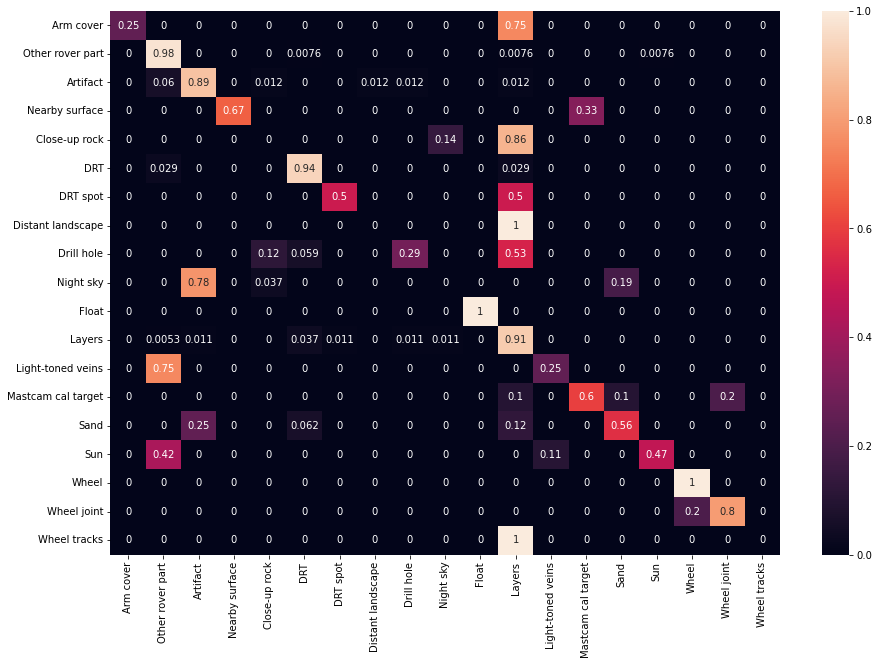

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, preds, normalize='true'), 
                         LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values, 
                         LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values), annot=True, ax=ax)

In [31]:
print(classification_report(y_true, preds, 
                            target_names=LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values,
                            digits=4, zero_division=0))

                    precision    recall  f1-score   support

         Arm cover     1.0000    0.2500    0.4000         4
  Other rover part     0.8776    0.9773    0.9247       132
          Artifact     0.7353    0.8929    0.8065        84
    Nearby surface     1.0000    0.6667    0.8000         6
     Close-up rock     0.0000    0.0000    0.0000         7
               DRT     0.7619    0.9412    0.8421        34
          DRT spot     0.7500    0.5000    0.6000        12
 Distant landscape     0.0000    0.0000    0.0000         1
        Drill hole     0.6250    0.2941    0.4000        17
         Night sky     0.0000    0.0000    0.0000        27
             Float     1.0000    1.0000    1.0000        29
            Layers     0.8424    0.9144    0.8769       187
 Light-toned veins     0.3333    0.2500    0.2857         4
Mastcam cal target     0.7500    0.6000    0.6667        10
              Sand     0.6000    0.5625    0.5806        16
               Sun     0.9000    0.4737

In [32]:
LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values

array(['Arm cover', 'Other rover part', 'Artifact', 'Nearby surface',
       'Close-up rock', 'DRT', 'DRT spot', 'Distant landscape',
       'Drill hole', 'Night sky', 'Float', 'Layers', 'Light-toned veins',
       'Mastcam cal target', 'Sand', 'Sun', 'Wheel', 'Wheel joint',
       'Wheel tracks'], dtype=object)

In [33]:
LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values

array(['Arm cover', 'Other rover part', 'Artifact', 'Nearby surface',
       'Close-up rock', 'DRT', 'DRT spot', 'Distant landscape',
       'Drill hole', 'Night sky', 'Float', 'Layers', 'Light-toned veins',
       'Mastcam cal target', 'Sand', 'Sun', 'Wheel', 'Wheel joint',
       'Wheel tracks'], dtype=object)

In [34]:
import csv

def read_class_label_map(csv_file):
    assert os.path.isfile(
        csv_file
    ), f"Provided file {csv_file} is not a valid CSV file."
    reader = csv.reader(open(csv_file, "r"))
    return {c: int(i) for (i, c) in reader}

def get_files_and_labels(
    folder: str, ext: str = "png", mapping: dict = None, metadata_file=None
):

    if metadata_file is not None:
        lines = open(metadata_file, "r").readlines()
        all_files = []
        labels = []
        for l in lines:
            file_label = l.strip().split(f".{ext}")
            file = file_label[0].strip() + f".{ext}"
            if len(file.split(os.path.sep)) <= 1:
                file = os.path.join(folder, file)
            all_files.append(file)
            labels.append(int(file_label[1].strip()))
        idx_mapping = None
    else:
        path = os.path.join(os.path.abspath(folder), "**", f"**.{ext}")
        all_files = glob(path, recursive=True)
        all_files = [f for f in all_files if f".{ext}" in f]
        assert len(all_files) > 0, f"Couldn't find any files in {path}"

        if mapping is None:
            #file_mapping --> file: class_index
            # idx_mapping --> class: index
            file_mapping, idx_mapping = infer_classes_from_filepaths(all_files)
            mapping = idx_mapping

        labels = [file_mapping[f] for f in all_files]
    return list(zip(all_files, labels)), len(all_files), len(set(labels)), mapping


In [35]:
class_mapping = read_class_label_map(f'{BASE_PATH}/class_map.csv')
X, num_files, num_classes, class_mapping = get_files_and_labels(
   '/home/kaipak/datasets/msl-labeled-data-set-v2.1/images' , ext="jpg", metadata_file='/home/kaipak/datasets/msl-labeled-data-set-v2.1/test-set-v2.1.txt', mapping=class_mapping
)

In [36]:
classes = list(class_mapping.keys())


def plot_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(14, 10))

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=classes)
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    accuracy = sklearn.metrics.accuracy_score(
        y_true, y_pred, sample_weight=None)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    sns.heatmap(cm, annot=True, cmap='viridis', fmt='.0f')
    ax.set_title(
        f"Finetuned on full training data (2900 images) - overall accuracy: {100*accuracy:.2f}%")

    plt.tight_layout()
#     plt.savefig(f"{ckpt}_test.png", transparent=True, bbox_inches='tight')
    plt.show()
    return fig, ax, cm, accuracy


def set_font_size(ax, fontsize=12):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)


def plot_precision_vs_recall(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(10, 8))

    cr = classification_report(
        y_true, y_pred, target_names=classes, output_dict=True)
    cr_df = pd.DataFrame.from_dict(cr).T

    # add "num_samples" column to classification report - should be equivalent to "Support" column
    num_examples = pd.DataFrame(
        pd.DataFrame(
            [classes[x[1]] for x in X],
            columns=['class']).value_counts(),
        columns=['num_samples']
    ).reset_index()    
    cr_df_with_counts = pd.merge(num_examples, cr_df.reset_index().rename(
        columns={'index': 'class'}), how='inner')

    mean_precision = cr_df.loc['macro avg', 'precision']
    mean_recall = cr_df.loc['macro avg', 'recall']
    mean_f1 = cr_df.loc['macro avg', 'f1-score']

    class_order = [
        'Arm cover', 'Other rover part', 'Artifact', 'Nearby surface',
        'Close-up rock', 'DRT', 'DRT spot', 'Distant landscape', 'Drill hole',
        'Night sky', 'Float', 'Layers', 'Light-toned veins', 'Mastcam cal target',
        'Sand', 'Sun', 'Wheel', 'Wheel joint', 'Wheel tracks'
    ]
    marker_order = [
        "o", "v", "^", "<", ">", "o", "s", "P", "p", "*", "X", "D", "d", "h", "H", "1", "2", "3", "4"
    ]
    kiri_markers = {c: m for c, m in zip(class_order, marker_order)}
    colors = list(plt.get_cmap('tab20').colors)
    colors.pop(class_order.index('Night sky'))

    cr_df_with_counts = cr_df_with_counts.sort_values(
        by='class', key=lambda x: [class_order.index(xx) for xx in x])
    for i in range(0, len(cr_df_with_counts)):
        x = cr_df_with_counts.iat[i, 3]  # recall
        y = cr_df_with_counts.iat[i, 2]  # precision
        cls = cr_df_with_counts.iat[i, 0]  # class
        n_min, n_max = cr_df_with_counts['num_samples'].min(
        ), cr_df_with_counts['num_samples'].max()
        s = 95
        alpha = 0.5 if np.isclose(x, 0) and np.isclose(y, 0) else 1
        label = cls + ' (at [0, 0])' if np.isclose(x,
                                                   0) and np.isclose(y, 0) else cls
        ax.scatter(x, y, s=s, c=[colors[i]],
                   marker=kiri_markers[cls], label=label, alpha=alpha)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim((-0.04, 1.04))
    ax.set_ylim((-0.04, 1.04))
    plt.grid(linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    set_font_size(ax, 14)
    plt.tight_layout()
    ax.set_aspect(1.)
    ax.text(
        x=0.65,
        y=0.05,
        s=(f"Mean precision: {mean_precision*100:.2f} %\n"
           f"Mean recall: {mean_recall*100:.2f} %\n"
           f"Mean F1: {mean_f1*100:.2f} %")
    )

#     plt.savefig(f"{ckpt}_precision_recall_test.png", transparent=True, bbox_inches='tight')
    plt.show()
    return fig, ax, cr_df_with_counts, mean_precision, mean_recall

/home/kaipak/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaipak/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaipak/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

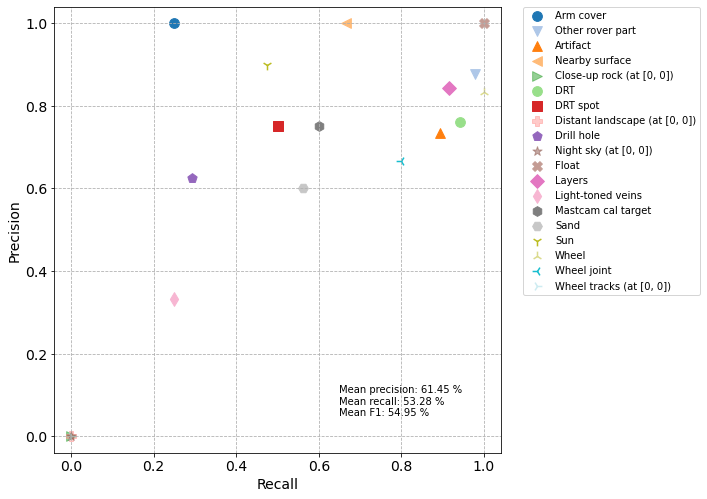

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:xlabel='Recall', ylabel='Precision'>,
                  class  num_samples  precision    recall  f1-score  support
 15           Arm cover            4   1.000000  0.250000  0.400000      4.0
 10    Other rover part           10   0.877551  0.977273  0.924731    132.0
 1             Artifact          132   0.735294  0.892857  0.806452     84.0
 0       Nearby surface          187   1.000000  0.666667  0.800000      6.0
 2        Close-up rock           84   0.000000  0.000000  0.000000      7.0
 12                 DRT            6   0.761905  0.941176  0.842105     34.0
 11            DRT spot            7   0.750000  0.500000  0.600000     12.0
 3    Distant landscape           34   0.000000  0.000000  0.000000      1.0
 9           Drill hole           12   0.625000  0.294118  0.400000     17.0
 16           Night sky            4   0.000000  0.000000  0.000000     27.0
 17               Float            1   1.000000  1.000000  1.0000

In [37]:
plot_precision_vs_recall(y_true, preds)

In [ ]:
classes